<a href="https://colab.research.google.com/github/kingsman-del/MoodSense/blob/main/text_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import gensim.downloader as api

In [ ]:
!wget -P /content/ -c "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

--2023-10-26 18:27:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.78, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘/content/wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   103MB/s    in 6.4s    

2023-10-26 18:27:51 (101 MB/s) - ‘/content/wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip /content/wiki-news-300d-1M.vec.zip

Archive:  /content/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
import urllib.request
import zipfile
import os
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,GRU,Dense
import nltk
from nltk.tokenize import word_tokenize
import warnings
import tensorflow as tf
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
f=open('/content/train.txt','r')
x_train=[]
y_train=[]
for i in f:
    l=i.split(';')
    y_train.append(l[1].strip())
    x_train.append(l[0])
f=open('/content/test.txt','r')
x_test=[]
y_test=[]
for i in f:
    l=i.split(';')
    y_test.append(l[1].strip())
    x_test.append(l[0])
f=open('/content/val.txt','r')
for i in f:
    l=i.split(';')
    y_test.append(l[1].strip())
    x_test.append(l[0])
data_train=pd.DataFrame({'Text':x_train,'Emotion':y_train})
data_test=pd.DataFrame({'Text':x_test,'Emotion':y_test})
data=data_train.append(data_test,ignore_index=True)

In [ ]:
def clean_text(data):
    data=re.sub(r"(#[\d\w\.]+)", '', data)
    data=re.sub(r"(@[\d\w\.]+)", '', data)
    data=word_tokenize(data)
    return data
texts=[' '.join(clean_text(text)) for text in data.Text]
texts_train=[' '.join(clean_text(text)) for text in x_train]
texts_test=[' '.join(clean_text(text)) for text in x_test]

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)
sequence_train=tokenizer.texts_to_sequences(texts_train)
sequence_test=tokenizer.texts_to_sequences(texts_test)
index_of_words=tokenizer.word_index
vocab_size=len(index_of_words)+1

In [ ]:
num_classes=6
embed_num_dims=300
max_seq_len=500
class_names=['anger','sadness','fear','joy','surprise','love']
X_train_pad=pad_sequences(sequence_train,maxlen=max_seq_len)
X_test_pad=pad_sequences(sequence_test,maxlen=max_seq_len)
encoding={'anger':0,'sadness':1,'fear':2,'joy':3,'surprise':4,'love':5}
y_train=[encoding[x] for x in data_train.Emotion]
y_test=[encoding[x] for x in data_test.Emotion]
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [ ]:
def create_embedding_matrix(filepath,word_index,embedding_dim):
    vocab_size=len(word_index)+1
    embedding_matrix=np.zeros((vocab_size,embedding_dim))
    with open(filepath) as f:
        for line in f:
            word,*vector=line.split()
            if word in word_index:
                idx=word_index[word]
                embedding_matrix[idx] = np.array(vector,dtype=np.float32)[:embedding_dim]
    return embedding_matrix
fname='/content/wiki-news-300d-1M.vec'
embedd_matrix=create_embedding_matrix(fname,index_of_words,embed_num_dims)

In [ ]:
embedd_layer=Embedding(vocab_size,embed_num_dims,input_length=max_seq_len,weights=[embedd_matrix],trainable=False)
gru_output_size=128
bidirectional=True
model=Sequential()
model.add(embedd_layer)
model.add(Bidirectional(GRU(units=gru_output_size,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size=128
epochs=8
hist=model.fit(X_train_pad,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test_pad,y_test))

Epoch 1/8
125/125 [==============================] - 929s 7s/step - loss: 1.3895 - accuracy: 0.4781 - val_loss: 1.1154 - val_accuracy: 0.5965
Epoch 2/8
125/125 [==============================] - 918s 7s/step - loss: 0.8738 - accuracy: 0.6909 - val_loss: 0.6101 - val_accuracy: 0.7868
Epoch 3/8
125/125 [==============================] - 963s 8s/step - loss: 0.4987 - accuracy: 0.8268 - val_loss: 0.3451 - val_accuracy: 0.8848
Epoch 4/8
125/125 [==============================] - 910s 7s/step - loss: 0.3208 - accuracy: 0.8891 - val_loss: 0.2457 - val_accuracy: 0.9137
Epoch 5/8
125/125 [==============================] - 957s 8s/step - loss: 0.2516 - accuracy: 0.9069 - val_loss: 0.2079 - val_accuracy: 0.9200
Epoch 6/8
125/125 [==============================] - 951s 8s/step - loss: 0.2210 - accuracy: 0.9164 - val_loss: 0.1929 - val_accuracy: 0.9195
Epoch 7/8
125/125 [==============================] - 901s 7s/step - loss: 0.1931 - accuracy: 0.9226 - val_loss: 0.1753 - val_accuracy: 0.9255
Epoch 

125/125 [==============================] - 56s 452ms/step - loss: 0.1627 - accuracy: 0.9275
Accuracy of our model on test data :  92.75000095367432 %


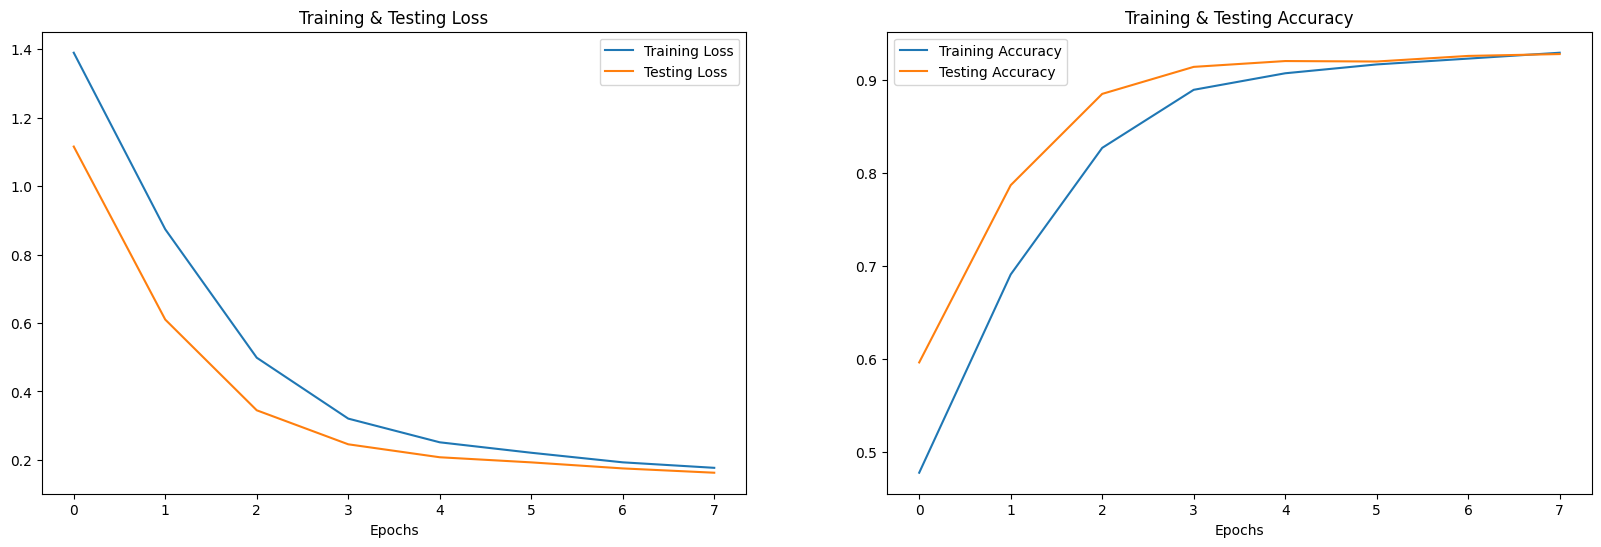

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test_pad,y_test)[1]*100 , "%")

epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
!pip install h5py

In [ ]:
model.save("/content/final_text_model.h5")

In [ ]:
pred_test = model.predict(X_test_pad)



125/125 [==============================] - 28s 223ms/step


In [ ]:
import numpy as np

# Assuming pred_test is of shape (num_samples, num_classes)
predicted_classes = np.argmax(pred_test, axis=1)

In [ ]:
predicted_classes

array([1, 1, 1, ..., 3, 5, 3])

In [ ]:
y_test1=np.argmax(y_test, axis=1)

In [ ]:
y_test1

array([1, 1, 1, ..., 3, 3, 3])

In [ ]:
print(classification_report(y_test1, predicted_classes))

              precision    recall  f1-score   support

           0       0.91      0.97      0.93       550
           1       0.97      0.95      0.96      1131
           2       0.90      0.88      0.89       436
           3       0.95      0.94      0.95      1399
           4       0.78      0.80      0.79       147
           5       0.85      0.85      0.85       337

    accuracy                           0.93      4000
   macro avg       0.89      0.90      0.89      4000
weighted avg       0.93      0.93      0.93      4000

